In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostClassifier

Задание 1.

Для выполнения задания вы можете самостоятельно создать Python-ноутбук, а в LMS прикладывать лишь требуемые результаты.

Будем работать с датасетом для предсказания оттока клиента.

Можно скачать датасет с google drive.

Целевой признак Churn

Считайте данные через pandas

Сделайте разбиение на обучение и тест с соотношением 80/20, со стратификацией по целевому признаку и random_state=1.

Удалите признак идентификатора клиента. Изучите признаки в тренировочном датасете, убедитесь, что типы данных соответствуют значениям в признаке.

Если есть не явные пропуски замените их в численных признаках на 0

Укажите в ответе, сколько категориальных/бинарных/численных признаков имеется в задаче.

In [82]:
df = pd.read_csv("./data.csv")

In [83]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [86]:
data = df.drop(columns=["customerID"])
# data["gender"] = data["gender"].apply(lambda x: 1 if x == "Female" else 0)
# data["Partner"] = data["Partner"].apply(lambda x: 1 if x == "Yes" else 0)
# data["Dependents"] = data["Dependents"].apply(lambda x: 1 if x == "Yes" else 0)
# data["PhoneService"] = data["PhoneService"].apply(lambda x: 1 if x == "Yes" else 0)
# data["PaperlessBilling"] = data["PaperlessBilling"].apply(lambda x: 1 if x == "Yes" else 0)
# data["Churn"] = data["Churn"].apply(lambda x: 1 if x == "Yes" else 0)
data["MonthlyCharges"] = pd.to_numeric(data["MonthlyCharges"])
data["TotalCharges"] = data["TotalCharges"].str.replace(" ", "0")
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"])

In [87]:
X = data.drop(columns=["Churn"])
y = data["Churn"]

In [88]:
binary = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "PaperlessBilling"]
categorical = [
    "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod",
    ]

print(f"Категориальныех переменных: {len(categorical)}")
print(f"Бинарных признаков: {len(binary)}")
print(f"Числовых признаков: {len(X.columns.to_list())- len(categorical) - len(binary)}")

Категориальныех переменных: 10
Бинарных признаков: 6
Числовых признаков: 3


In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

---
Задание 2.

Продолжайте работать с датасетом для предсказания оттока клиента.

Преобразуйте бинарные признаки через OrdinalEncoder, а категориальные - через OneHotEncoder (с параметром sparse_output=False).

Не забудьте удалить преобразованные категориальные колонки из выборок.

Какая получилась размерность у тренировочной и тестовой выборок?

Пример ввода: 1000, 10 (после запятой пробел)

In [90]:
# Преобразуем бинарные признаки через OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
X_train[binary] = ordinal_encoder.fit_transform(X_train[binary])
X_test[binary] = ordinal_encoder.transform(X_test[binary])

# Преобразуем категориальные признаки через OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)  # Обратите внимание на используемый параметр
X_train_encoded = onehot_encoder.fit_transform(X_train[categorical])
X_test_encoded = onehot_encoder.transform(X_test[categorical])

# Создаем DataFrame с закодированными категориальными признаками
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=onehot_encoder.get_feature_names_out(categorical))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=onehot_encoder.get_feature_names_out(categorical))

# Удаляем исходные категориальные колонки из тренировочной и тестовой выборок
X_train = X_train.drop(columns=categorical).reset_index(drop=True)
X_test = X_test.drop(columns=categorical).reset_index(drop=True)

# Объединяем закодированные признаки с основными
X_train_transformed = pd.concat([X_train, X_train_encoded_df.reset_index(drop=True)], axis=1)
X_test_transformed = pd.concat([X_test, X_test_encoded_df.reset_index(drop=True)], axis=1)

# Проверяем размерности
train_shape = X_train_transformed.shape
test_shape = X_test_transformed.shape

# Выводим размеры
print(f"{train_shape[0]}, {train_shape[1]}")  # Размеры обучающей выборки
print(f"{test_shape[0]}, {test_shape[1]}")  # Размеры тестовой выборки

5634, 40
1409, 40


In [91]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('ord', OrdinalEncoder(), binary),
#         ('ohe', OneHotEncoder(), categorical)
#     ]
# )

# # Применяем трансформер к обучающей выборке
# X_train_transformed = preprocessor.fit_transform(X_train)
# X_test_transformed = preprocessor.transform(X_test)

# # Проверяем размерности
# train_shape = X_train_transformed.shape
# test_shape = X_test_transformed.shape

# # Выводим размеры
# print(f"{train_shape[0]}, {train_shape[1]} тренировочная выборка")  # Размеры обучающей выборки
# print(f"{test_shape[0]}, {test_shape[1]} тестовая выборка")  # Размеры тестовой выборки


---
Задание 3.

Продолжайте работать с датасетом для предсказания оттока клиента.

Обучите случайный лес на базовых гиперпараметрах с фиксированным random_state=1 и посчитайте метрику f1 с усреднением macro на тренировочной и тестовой выборках.

Обучите градиентный бустинг из sklearn на базовых гиперпараметрах с фиксированным random_state=1 и посчитайте метрику f1 с усреднением macro на тренировочной и тестовой выборках.

Укажите, на сколько метрика на тесте на градиентном бустинге лучше, чем на случайном лесу, округлив до второго знака после точки.

In [92]:
# Обучение модели случайного леса
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train_transformed, y_train)

# Прогноз для тренировочной и тестовой выборок
y_train_pred_rf = rf_model.predict(X_train_transformed)
y_test_pred_rf = rf_model.predict(X_test_transformed)

# Рассчитываем метрику F1 для случайного леса
f1_train_rf = f1_score(y_train, y_train_pred_rf, average='macro')
f1_test_rf = f1_score(y_test, y_test_pred_rf, average='macro')

# Обучение модели градиентного бустинга
gb_model = GradientBoostingClassifier(random_state=1)
gb_model.fit(X_train_transformed, y_train)

# Прогноз для тренировочной и тестовой выборок
y_train_pred_gb = gb_model.predict(X_train_transformed)
y_test_pred_gb = gb_model.predict(X_test_transformed)

# Рассчитываем метрику F1 для градиентного бустинга
f1_train_gb = f1_score(y_train, y_train_pred_gb, average='macro')
f1_test_gb = f1_score(y_test, y_test_pred_gb, average='macro')

# Выводим результаты
print(f"Random Forest - Train F1: {f1_train_rf:.4f}, Test F1: {f1_test_rf:.4f}")
print(f"Gradient Boosting - Train F1: {f1_train_gb:.4f}, Test F1: {f1_test_gb:.4f}")

# На сколько метрика теста на градиентном бустинге лучше, чем на случайном лесу
improvement = round(f1_test_gb - f1_test_rf, 2)
print(f"Improvement of Gradient Boosting over Random Forest on test set: {improvement}")

Random Forest - Train F1: 0.9975, Test F1: 0.7104
Gradient Boosting - Train F1: 0.7606, Test F1: 0.7313
Improvement of Gradient Boosting over Random Forest on test set: 0.02


---
Задание 4.

Продолжайте работать с датасетом для предсказания оттока клиента.

У модели градиентный бустинг оставьте параметр random_state=1. Измените глубину деревьев от 1 до 20 с шагом 1.

Визуализируйте изменение метрики f1 macro на тренировочной и тестовой выборках от параметра глубины.

Выберите правильный вывод.


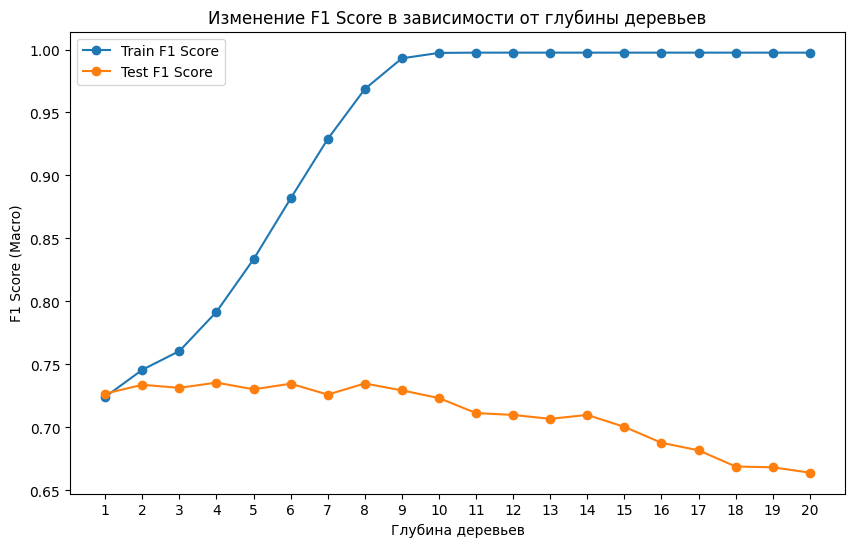

In [76]:
# Параметры для градиентного бустинга
depths = range(1, 21)
f1_train_scores = []
f1_test_scores = []

# Цикл по глубине деревьев
for depth in depths:
    gb_model = GradientBoostingClassifier(max_depth=depth, random_state=1)
    gb_model.fit(X_train_transformed, y_train)

    # Прогнозируем
    y_train_pred = gb_model.predict(X_train_transformed)
    y_test_pred = gb_model.predict(X_test_transformed)

    # Считаем метрики F1
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    f1_test = f1_score(y_test, y_test_pred, average='macro')

    f1_train_scores.append(f1_train)
    f1_test_scores.append(f1_test)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(depths, f1_train_scores, label='Train F1 Score', marker='o')
plt.plot(depths, f1_test_scores, label='Test F1 Score', marker='o')
plt.title('Изменение F1 Score в зависимости от глубины деревьев')
plt.xlabel('Глубина деревьев')
plt.ylabel('F1 Score (Macro)')
plt.xticks(depths)
plt.legend()

---
Задание 5.
Продолжайте работать с датасетом для предсказания оттока клиента.

У модели градиентный бустинг оставьте параметр random_state=1. Измените скорость обучения от 0.1 до 0.9 с шагом 0.1.

Визуализируйте изменение метрики f1 macro на тренировочной и тестовой выборках от параметра скорости обучения.

Выберите правильный вывод.
Выберите один ответ:

Параметр learning_rate не влияет на качество градиентного бустинга на тесте

Увеличение до разумных пределов параметра learning_rate в градиентном бустинге ухудшает качество модели на тесте

Увеличение до разумных пределов параметра learning_rate в градиентном бустинге улучшает качество модели на тесте

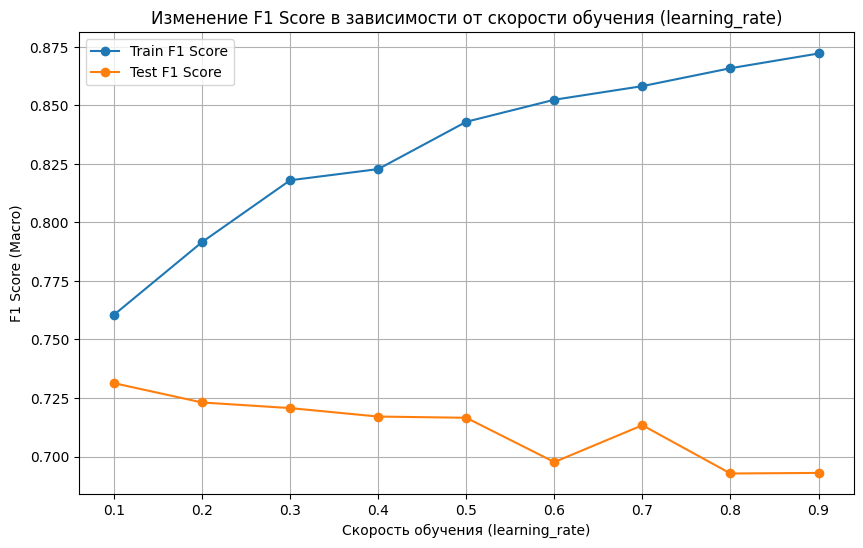

In [77]:
# Параметры для градиентного бустинга
learning_rates = np.arange(0.1, 1.0, 0.1)
f1_train_scores = []
f1_test_scores = []

# Цикл по скорости обучения
for lr in learning_rates:
    gb_model = GradientBoostingClassifier(learning_rate=lr, random_state=1)
    gb_model.fit(X_train_transformed, y_train)
    
    # Прогнозируем
    y_train_pred = gb_model.predict(X_train_transformed)
    y_test_pred = gb_model.predict(X_test_transformed)
    
    # Считаем метрики F1
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    f1_test = f1_score(y_test, y_test_pred, average='macro')
    
    f1_train_scores.append(f1_train)
    f1_test_scores.append(f1_test)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, f1_train_scores, label='Train F1 Score', marker='o')
plt.plot(learning_rates, f1_test_scores, label='Test F1 Score', marker='o')
plt.title('Изменение F1 Score в зависимости от скорости обучения (learning_rate)')
plt.xlabel('Скорость обучения (learning_rate)')
plt.ylabel('F1 Score (Macro)')
plt.xticks(learning_rates)
plt.legend()
plt.grid()
plt.show()

---
Задание 6.
Продолжайте работать с датасетом для предсказания оттока клиента.

Обучите модель CatBoost с параметрами random_state=1, n_estimators=100 на данных без не явных пропусков, без идентификатора клиента и без предобработанных категориальных и бинарных переменных, передав в параметр cat_features модели список категориальных и бинарных признаков.

Укажите метрику F1 macro на тестовой выборке, округлив ее до третьего знака после точки.



In [95]:
data = df.drop(columns=["customerID"])
X = data.drop(columns=["Churn"])
y = data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

binary = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "PaperlessBilling"]
categorical = [
    "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod",
    ]


In [96]:
# Объединяем бинарные и категориальные признаки для передачи в cat_features
cat_features = binary + categorical

# Обучаем модель CatBoost
model = CatBoostClassifier(random_state=1, n_estimators=100, cat_features=cat_features, verbose=0)
model.fit(X_train, y_train)

# Прогнозируем на тестовой выборке
y_test_pred = model.predict(X_test)

# Рассчитываем метрику F1 macro
f1_macro = f1_score(y_test, y_test_pred, average='macro')

# Выводим результат, округляя до третьего знака после запятой
print(f"F1 Macro на тестовой выборке: {f1_macro:.3f}")

F1 Macro на тестовой выборке: 0.749


---
Задание 7.

Продолжайте работать с датасетом для предсказания оттока клиента.

В этом задании будем делать свой градиентный бустинг.

Нужно сделать класс с методами:

_ _init_ _ - на вход передаются параметры n_estimators, learning_rate, max_depth

fit - на вход передаются параметры X, y

predict - на вход передаются параметры X, y

Первое предсказание сделайте, как среднее целевых значений на тренировочной выборке, последующие - предсказания отклонений (y - y_hat). Пользуйтесь деревьями решений для задачи регрессии, фиксируйте у них random_state номером дерева в ансамбле, начиная с 0.

Можете воспользоваться заготовкой.

Обучите получившуюся модель на тренировочной выборке, где обработаны пропуски и категории, сделайте предсказания на тестовой выборке и укажите метрику качества f1 macro, округлив её до третьего знака после точки. Например. 0,111

In [97]:
class GradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.base_pred = None

    def fit(self, X, y):
        # Инициализация предсказаний как среднее значение целевой переменной
        self.base_pred = np.mean(y)
        y_hat = np.full(y.shape, self.base_pred)
        residuals = y - y_hat

        for i in range(self.n_estimators):
            # Обучение дерева на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=i)
            tree.fit(X, residuals)
            self.trees.append(tree)

            # Получаем предсказание текущей моделью
            predictions = tree.predict(X)

            # Добавляем предсказание текущей модели в весь бустинг
            y_hat += self.learning_rate * predictions
            residuals = y - (y_hat)

    def predict(self, X):
        y_hat = np.full(X.shape[0], self.base_pred)  # Начальные предсказания
        for tree in self.trees:
            y_hat += self.learning_rate * tree.predict(X)
        return np.where(y_hat > 0.5, 1, 0)  # Бинарная классификация

# Обучаем модель
model = GradientBoosting(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train_transformed, y_train)

# Делаем предсказания на тестовой выборке
y_test_pred = model.predict(X_test_transformed)

# Рассчитываем метрику F1 macro
f1_macro = f1_score(y_test, y_test_pred, average='macro')

# Выводим результат, округляя до третьего знака после запятой
print(f"F1 Macro на тестовой выборке: {f1_macro:.3f}")

TypeError: Could not convert NoYesNoNoNoYesNoNoNoYesNoNoNoYesNoNoNoNoNoYesNoNoYesNoNoNoNoYesNoNoNoYesNoNoNoYesYesYesNoYesYesNoNoNoNoNoYesYesNoNoNoYesNoNoYesNoNoNoNoYesNoNoYesYesNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoYesYesNoYesNoYesNoNoNoYesYesNoNoYesYesNoNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoYesYesNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoNoYesYesNoNoNoNoNoNoYesYesNoYesYesNoNoNoNoNoYesNoYesNoNoYesYesYesNoYesNoNoNoNoNoNoNoNoYesYesNoNoNoNoNoNoNoYesNoNoNoNoNoNoYesNoYesYesNoYesYesNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoYesYesYesNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoYesNoNoYesNoNoNoYesYesYesNoNoNoYesNoNoNoNoYesNoNoNoNoNoNoNoYesNoNoNoNoYesNoYesNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoYesNoNoNoYesNoNoNoNoNoNoNoNoYesYesNoNoNoNoNoNoYesYesNoYesYesNoNoNoNoNoNoNoNoNoYesNoNoYesNoNoYesNoNoYesYesNoYesYesNoNoNoYesNoYesNoYesYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoYesNoNoNoYesNoNoNoYesNoNoYesNoNoNoYesNoNoYesNoYesNoYesNoYesYesNoNoYesYesNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoYesYesNoYesNoNoNoYesNoNoNoNoNoNoYesNoNoYesNoNoNoNoYesNoNoNoYesNoNoNoNoYesNoNoNoNoNoNoYesNoYesYesYesNoYesYesYesNoNoNoYesYesNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoYesNoYesNoNoNoNoYesNoYesNoYesNoNoNoNoNoNoYesYesNoYesNoNoNoNoNoNoNoNoNoNoNoYesYesYesNoNoYesNoNoYesNoNoYesNoNoNoNoYesNoNoYesNoNoNoYesNoNoNoNoNoNoNoNoNoNoYesNoNoYesYesYesNoNoNoYesYesNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoYesYesNoNoNoNoYesYesNoNoYesNoNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoYesYesNoNoNoNoYesNoNoYesYesNoYesYesNoNoYesNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoYesYesNoNoNoNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoNoYesNoNoNoYesYesYesNoNoYesYesYesYesNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoYesYesNoYesNoNoYesNoNoYesNoNoNoYesNoYesNoNoYesYesNoNoNoYesNoYesNoNoNoNoNoNoYesNoNoYesNoNoNoYesYesNoNoYesNoNoNoNoNoYesYesNoNoNoNoNoYesNoNoYesNoNoYesNoNoNoNoNoYesYesNoNoYesNoNoNoYesYesNoNoNoNoNoNoYesNoNoNoNoNoYesNoNoNoYesYesNoNoNoNoNoYesNoNoNoNoNoYesNoYesNoNoYesNoNoNoNoNoNoYesNoNoNoYesNoNoNoYesNoNoNoYesNoNoNoNoYesYesNoNoYesYesYesNoNoYesNoNoNoNoYesNoNoNoYesYesYesNoYesYesNoYesNoYesNoYesNoYesNoNoNoYesNoNoNoNoYesNoYesNoYesYesYesNoNoNoNoNoNoYesNoNoNoNoYesNoYesNoYesNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoNoYesYesNoYesNoNoNoNoNoYesYesYesNoNoNoNoNoNoNoNoYesNoNoYesYesNoYesNoNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoYesNoNoNoNoYesNoNoYesYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoYesNoYesYesNoNoNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoYesNoYesYesNoNoNoYesNoYesNoYesNoNoYesNoNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoYesNoNoNoYesNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoYesNoYesNoYesNoNoNoYesYesNoNoNoNoNoNoYesNoNoNoYesNoNoYesNoNoNoNoNoYesNoYesNoNoNoNoYesNoNoYesNoNoNoNoNoNoNoNoYesYesYesNoYesYesNoNoNoYesYesYesNoYesNoNoNoNoYesYesNoNoNoYesNoNoNoNoYesNoNoYesNoYesNoNoYesNoNoYesNoNoNoNoYesNoNoNoYesNoNoNoNoYesYesYesNoNoYesNoNoNoNoNoNoNoYesNoYesNoYesYesNoNoYesNoNoNoNoNoNoNoNoYesYesYesNoNoNoNoNoYesNoYesNoYesNoNoNoNoNoNoNoNoNoNoYesNoYesYesNoYesNoNoYesNoYesNoNoNoYesNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoNoYesYesNoYesNoNoNoNoNoNoYesNoNoNoYesNoNoYesNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoYesNoYesNoNoYesNoYesNoYesNoYesNoNoYesNoNoNoYesNoYesNoNoNoYesNoNoYesNoYesNoYesNoNoNoNoYesYesNoNoYesNoNoYesNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoNoYesNoYesNoNoYesYesNoNoNoYesNoNoYesNoNoNoNoNoYesNoNoYesYesNoYesYesNoYesYesNoYesNoNoNoYesYesNoNoNoNoNoNoYesNoNoNoYesNoNoYesNoNoNoYesYesNoNoNoNoNoNoNoNoYesNoNoYesNoNoNoNoNoNoNoNoNoNoYesNoNoYesYesYesNoNoYesNoNoNoNoYesNoYesNoNoNoNoNoNoNoYesNoYesYesYesYesNoNoYesYesNoNoNoNoYesNoYesYesYesNoYesYesNoYesYesNoNoYesYesNoYesYesYesNoNoNoYesNoYesNoNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoYesNoNoYesNoNoYesNoNoYesNoNoNoNoNoNoYesYesNoNoNoYesYesYesNoYesYesNoNoNoNoYesNoNoNoNoYesNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoNoYesYesNoYesNoYesNoNoYesNoNoYesNoNoYesYesNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoYesYesNoNoNoNoNoYesNoYesNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoYesNoYesNoNoNoYesNoYesNoNoNoNoNoNoYesNoNoNoYesNoNoNoNoNoYesNoYesYesNoYesNoYesYesNoYesYesYesNoNoYesYesNoNoNoNoNoNoYesYesYesNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoYesNoYesNoNoNoNoNoYesNoNoYesNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoNoYesNoYesYesYesNoNoNoYesNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesYesYesYesYesNoYesNoNoNoYesNoNoNoYesNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoNoNoYesNoNoNoNoYesYesNoNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoYesYesNoYesNoNoNoNoNoNoNoYesNoYesNoNoNoYesNoNoYesNoNoYesNoYesNoYesYesNoYesNoNoNoNoNoNoNoNoYesYesNoNoNoNoNoYesNoNoYesNoNoNoNoYesNoNoNoNoYesNoYesNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoNoYesYesNoNoNoNoNoNoYesNoYesNoNoYesNoNoYesYesNoYesYesNoNoNoNoYesNoNoNoYesNoNoNoNoYesYesNoNoNoNoNoNoYesNoNoNoYesYesNoYesNoYesNoYesNoNoNoNoNoNoNoNoYesYesNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoYesNoYesNoNoNoNoNoNoNoYesYesNoYesNoNoNoNoNoNoNoNoNoNoYesNoNoYesNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoYesNoNoYesNoNoNoYesNoNoNoNoNoNoNoYesYesYesYesNoYesYesNoNoYesYesNoNoYesYesNoNoYesNoNoYesNoNoYesNoNoNoYesNoNoNoNoYesYesNoNoNoNoNoNoNoNoNoYesNoYesYesYesNoNoYesNoNoNoNoNoNoNoNoNoNoYesYesNoYesNoNoNoNoNoNoNoYesNoNoNoNoYesNoYesNoYesNoNoNoYesNoNoNoYesYesNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoYesYesYesNoNoNoNoNoYesYesNoNoYesNoYesNoNoNoNoNoNoYesNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoYesNoNoNoYesNoNoNoNoNoYesNoNoNoNoNoYesYesNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoYesNoNoYesYesNoNoNoNoYesNoYesYesNoNoNoNoYesNoYesNoNoYesYesYesNoNoNoNoYesYesYesNoNoNoNoYesNoNoNoYesNoYesNoNoNoYesNoYesNoNoYesYesYesNoNoYesNoYesNoNoNoNoNoNoNoNoNoYesYesYesNoYesYesNoYesYesNoNoNoNoNoYesNoNoYesYesNoYesNoNoYesYesYesNoNoNoYesYesYesYesNoNoYesNoYesNoNoYesNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoYesNoNoNoYesNoYesNoNoYesNoNoNoNoNoNoNoNoNoYesNoNoYesNoNoNoNoNoNoNoNoYesYesNoNoNoNoNoNoYesNoNoNoNoNoYesNoNoYesNoNoNoNoYesNoYesYesNoNoNoYesNoYesNoYesNoYesNoYesNoYesYesNoYesYesNoNoNoYesNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoYesYesNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoYesNoYesNoYesNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoYesYesNoNoYesNoNoNoNoNoNoNoYesNoYesNoYesYesNoNoNoNoNoNoYesYesNoNoYesYesYesNoYesNoNoYesNoNoNoNoNoNoNoNoNoYesYesNoNoYesNoYesNoNoYesNoNoYesYesNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoNoYesNoNoNoNoYesNoNoNoYesNoNoYesNoYesYesNoYesYesNoYesYesNoNoNoYesNoNoNoYesNoYesNoNoYesNoNoNoNoNoNoNoNoNoYesYesNoNoYesNoNoNoYesNoYesYesYesNoNoNoNoYesNoNoNoYesYesNoYesNoNoNoYesNoYesYesNoNoNoNoYesNoYesNoNoYesYesNoYesYesNoNoYesYesNoYesNoNoYesYesNoNoYesYesNoNoNoNoNoNoNoYesNoNoNoYesYesNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoYesYesNoNoYesNoNoYesYesNoNoNoYesNoNoYesNoNoNoNoYesNoYesYesYesNoNoNoYesNoYesNoYesNoYesNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoYesNoNoYesNoNoYesNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoYesNoNoNoYesYesNoNoNoNoNoNoNoNoYesNoNoNoYesNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoYesYesNoNoNoNoNoNoYesYesNoNoNoYesYesYesNoYesYesNoYesNoNoNoNoYesYesNoNoYesNoNoNoYesYesNoNoNoNoNoYesNoNoNoYesNoNoNoNoNoYesNoNoNoNoYesNoYesNoNoNoNoYesYesNoNoNoYesNoYesNoNoNoNoNoYesNoNoNoYesYesNoNoNoYesYesNoYesYesNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoYesYesYesNoYesNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoYesYesNoNoYesNoNoYesNoNoNoNoNoNoNoNoYesYesYesYesNoNoNoNoNoYesYesYesNoNoNoYesYesNoNoNoNoNoYesNoNoNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoYesNoNoNoNoNoYesNoNoNoNoNoNoNoYesNoYesNoYesYesNoYesNoYesNoYesNoNoNoNoNoYesNoYesNoNoNoYesNoNoNoNoNoNoYesYesYesNoYesNoYesNoYesNoNoYesNoNoNoNoNoYesNoNoYesNoNoNoNoNoNoYesNoYesNoNoNoNoYesNoNoNoNoNoYesYesYesNoYesNoNoYesNoYesNoYesYesNoNoYesYesNoYesYesNoNoNoYesNoNoYesYesYesYesNoNoYesNoNoNoYesNoNoNoNoYesNoYesNoNoYesYesNoYesYesNoYesYesYesYesYesNoNoYesYesNoNoNoNoYesNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoYesYesYesYesNoNoNoNoNoYesYesYesYesNoYesNoNoYesNoNoNoNoNoNoYesNoNoNoNoNoYesNoNoYesNoYesYesNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoYesNoYesNoNoNoYesNoNoNoNoNoNoNoNoYesNoYesNoYesNoNoNoYesNoNoNoYesNoNoNoNoYesNoNoNoNoYesYesNoNoNoNoYesNoNoNoYesNoNoNoNoNoNoYesNoYesYesNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoYesNoNoNoYesNoNoNoNoNoNoNoYesNoYesNoNoYesNoYesNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoNoYesYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoYesYesYesYesNoYesYesNoYesNoNoYesYesNoNoYesNoNoNoNoYesNoNoNoNoYesNoYesNoYesNoYesYesNoNoNoNoNoNoYesYesNoNoNoNoNoNoYesNoNoNoYesNoNoNoYesNoNoNoNoYesNoNoNoNoNoNoNoNoNoYesNoNoNoNoYesYesNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoNoNoNoYesNoNoYesNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoYesNoYesYesNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoYesYesYesNoNoNoYesNoNoYesNoNoNoNoYesNoYesNoNoNoNoNoYesNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoYesNoNoNoYesNoNoNoYesNoNoYesNoNoNoNoYesYesYesNoYesNoYesNoYesYesNoNoNoYesNoNoNoNoYesNoYesYesNoYesNoYesNoYesNoNoNoNoNoNoNoYesNoNoNoNoYesNoYesNoNoNoNoNoYesYesNoNoNoNoNoNoYesYesYesNoNoNoYesNoNoNoNoNoYesNoNoNoNoNoNoYesNoYesNoNoNoYesNoNoYesNoNoNoNoYesYesNoYesNoNoNoNoYesNoNoNoNoNoNoNoYesNoNoNoYesNoYesNoYesYesNoYesYesYesNoNoYesNoYesNoNoNoNoYesNoNoYesNoNoYesNoNoYesNoNoNoNoNoNoNoYesNoNoNoNoNoYesNoNoNoYesNoNoNoNoNoNoYesNoNoNoNoYesNoYesYesNoNoNoNoNoNoYesYesYesNoNoYesNoYesYesNoNoNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoYesYesNoNoNoYesNoNoNoNoNoNoNoNoNoYesYesYesNoNoNoNoNoNoNoYesYesNoNoYesNoNoNoYesNoNoYesYesNoNoNoNoNoNoNoNoNoYesNoNoYesYesNoNoYesYesNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoYesYesNoNoYesNoNoYesNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoYesNoNoNoNoYesNoYesYesYesNoNoYesNoYesYesNoYesNoNoYesYesNoNoNoNoNoNoNoNoYesNoNoNoYesNoNoNoYesNoNoNoYesNoYesNoNoYesNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoYesNoYesYesNoYesYesNoNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoYesYesNoYesNoYesNoYesNoYesYesNoYesNoYesNoNoNoYesNoNoNoYesNoNoNoYesNoNoNoYesYesNoNoNoNoNoNoNoNoNoYesNoNoNoYesYesYesNoNoNoNoNoNoYesNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoNoYesNoNoYesYesNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoYesYesYesNoNoYesNoYesYesYesNoYesNoNoYesNoNoNoNoYesNoNoNoYesNoYesYesNoNoNoNoYesYesNoNoNoNoNoNoNoYesNoYesNoNoNoYesNoNoNoNoNoYesNoYesNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoYesNoNoYesNoNoNoNoNoNoNoYesNoYesYesNoNoNoNoNoNoNoYesNoNoNoYesNoNoYesNoYesNoYesYesNoNoNoYesNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoYesNoYesYesNoYesNoYesNoYesYesYesYesNoYesNoNoNoNoYesNoNoYesNoNoNoNoNoYesNoNoNoNoNoNoNoYesNoNoYesYesNoNoNoNoNoNoNoNoYesYesYesYesNoNoNoNoNoNoYesYesNoNoNoNoYesNoNoNoNoYesYesNoNoNoNoNoNoNoYesNoYesYesNoNoYesNoNoYesNoNoNoNoYesYesNoNoNoNoYesNoNoNoYesYesNoYesYesNoNoNoNoYesNoNoNoYesNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoYesNoNoNoYesNoNoYesYesNoYesYesNoNoNoNoNoNoYesNoYesYesNoNoNoNoNoNoYesNoYesYesNoYesNoNoYesNoNoYesNoYesYesNoYesNoNoYesNoNoNoNoNoNoNoNoYesYesYesYesNoNoNoNoNoNoNoNoNoYesNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoYesNoNoNoNoNoYesNoYesNoNoNoNoYesYesNoNoNoNoYesNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoYesNoYesNoYesNoYesYesYesNoNoNoNoNoNoNoNoYesYesYesNoYesYesNoNoNoYesNoNoNoNoNoNoNoNoNoNoYesYesYesNoNoNoNoNoNoNoNoNoNoYesNoYesNoYesYesNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoYesNoYesYesYesNoNoYesYesNoNoNoNoNoNoYesNoNoNoYesNoNoYesNoNoNoYesNoNoYesYesNoYesNoYesYesNoNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoYesNoNoNoYesNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoNoNoYesNoNoNoNoNoNoYesNoYesNoNoNoNoYesNoNoNoNoNoNoYesYesNoNoYesNoNoNoYesYesNoNoNoYesNoNoYesYesNoNoNoNoNoNoNoYesNoNoNoYesNoNoNoNoNoNoNoNoYesYesNoYesNoNoYesNoYesNoNoNoNoYesNoNoNoNoNoNoNoYesNoYesYesYesYesNoYesNoNoNoYesYesNoNoNoNoYesNoNoYesYesNoYesYesYesNoNoYesNoYesYesNoNoNoNoYesYesYesNoNoNoNoYesYesYesYesNoNoNoNoNoYesYesYesNoYesNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoNoNoYesYesNoYesNoYesNoNoNoNoYesNoNoNoNoYesNoNoNoYesNoNoNoNoYesNoYesNoNoYesNoNoYesNoNoNoYesYesNoNoYesNoNoYesNoNoNoNoNoYesNoNoNoNoNoYesNoNoYesNoNoNoNoYesNoNoYesNoYesNoYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoNoNoNoYesYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoYesNoYesYesNoYesNoYesNoNoYesNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoNoNoYesYesYesNoNoNoNoNoNoNoYesNoYesNoNoYesNoYesYesYesNoNoYesNoYesNoNoYesNoNoNoNoNoNoNoNoNoYesNoNoNoYesNoNoNoNoYesNoNoYesNoYesNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoNoNoNoYesNoNoNoNoYesNoNoNoNoYesNoYesNoNoNoNoNoNoNoNoNoNoNoNoYesYesNoYesYesYesNoNoNoYesNoNoYesNoNoNoYesNoYesNoNoNoYesYesNoYesNoNoYesYesNoNoYesNoNoNoNoNoNoNoYesNoNoYesNoNoNoYesYesNoYesYesYesYesNoNoNoNoNoNoYesNoYesNoNoNoNoNoNoYesNoNoYesYesNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoYesNoNoYesNoNoYesYesNoYesNoNoNoNoNoYesNoYesNoNoNoNoNoYesNoNoYesYesYesNoNoNoNoYesYesNoNoNoNoNoNoNoYesNoYesNoNoYesNoNoYesYesNoNoNoNoNoNoNoNoNoYesYesYesNoNoNoNoNoNoNoNoYesNoYesNoNoYesNoNoNoNoYesNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoYesNoYesNoNoYesNoNoNoYesNoNoNoYesYesYesYesYesYesYesNoNoNoNoYesYesNoYesYesNoNoNoNoNoYesNoNoNoYesNoYesNoNoYesNoNoNoYesNoNoNoYesNoNoNoNoNoNoYesNoNoYesNoNoYesYesYesYesYesYesYesYesNoYesYesNoYesNoNoNoNoNoYesNoYesYesNo to numeric